# Домашнее задание 3. Алгоритмы кластеризации

Основная задача этого задания -- реализация одного из алгоритмов кластеризации. Кроме того, мы научимся подбирать параметры алгоритма, визуализируем результат кластеризации и попытаемся проанализировать природу полученных кластеров.

In [168]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.spatial as ss
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


Cчитываем данные, полученные в результате выполнения предыдущего домашнего задания, в `data frame` библиотеки `pandas`. Конвертируем данные в массив `numpy`.

In [169]:
data_df = pd.read_csv("hw2_out.csv", sep="\t", header=0, index_col="uid")
x = data_df.values

Алгоритм кластеризации, который необходимо реализовать, выбирается на основании Вашего логина на портале Техносферы. При проверке домашнего задания бадут осуществляться проверка логина и соответствующего алгоритма.

In [170]:
algorithms = [
    u"Gaussian Mixture Model с использованием maximum a-posteriori для выбора кластера (параметр - k)",
    u"Hierarchical clustering с поддержкой single-linkage, complete-linkage, average-linkage (параметры - k, linkage)",
    u"DBSCAN. (параметры  - epsilon, min_pts)", 
    u"OPTICS. (параметры - epsilon, min_pts)"
]

my_algorithm = algorithms[hash("a.slivkina") % len(algorithms)]
print u"Реализуем алгоритм кластеризации '%s'" % my_algorithm

Реализуем алгоритм кластеризации 'Gaussian Mixture Model с использованием maximum a-posteriori для выбора кластера (параметр - k)'


Алгоритм кластеризации должен удовлетворять следующему интерфейсу. Конструктор принимает набор параметров, необходимых для работы алгоритма кластеризации. Метод `fit` подсчитывает параметры модели и возвращает `self`. Метод `predict` возвращает вектор с индексами кластеров для поданных в него объектов `x`

In [171]:
from scipy.cluster import *
from scipy.misc import logsumexp
import scipy.linalg as linalg

#Вычисление логарифма нормального многомерного распределения по формуле из слайда
def find_lgn(X, mean, cov):
    D = X.shape[1]
    L = np.linalg.cholesky(cov)
    A = 2.0 * np.sum(np.log(np.diag(L)))
    U = linalg.solve_triangular(L, (X - mean[np.newaxis, :]).T)
    B = np.sum(U * U, axis=0)
    log_pi = np.log(2.0 * np.pi)
    res = -0.5 * A - 0.5 * D * log_pi - 0.5 * B
    return res

#Вычисление функции правдопадобия
def find_credibility(w, lgn):
    credibility = np.mean(logsumexp(lgn, b=w))
    return credibility

#находим апостериорную вероятность
def find_posterior(X, w, m, C, lgn):
    size_aprior = w.shape[0]
    N = X.shape[0]
    K = w.shape[0]
    multi_norm_distr = np.max(lgn, axis=0)
    log_multi_norm = lgn - multi_norm_distr
    multi_norm = np.exp(log_multi_norm)
    
    weight = w.reshape(1, K) * multi_norm
    sum_weight = np.sum(weight, axis=1)
    posteriori = weight / (sum_weight.reshape(N, 1) + 1e-6) 
    return posteriori

#находим вектор средних
def find_means(posteriori, N_k, X):
    vector = np.empty((X.shape[1]))
    vector = np.dot(posteriori.T, X)
    K=N_k.shape[0]
    vector = vector /N_k.reshape(K, 1)
    return vector

#находим матрицу ковариации
def find_cov_matrix(posteriori, N_k, X, vector_means):
    D = X.shape[1]
    N = X.shape[0]
    K = N_k.shape[0]
    C = np.empty((K, D, D))
    for i in range(K):
        multiplication = np.dot((X - vector_means[i]).T, posteriori[:, i].reshape(N, 1) * (X - vector_means[i]))
        C[i] = multiplication / N_k[i]
    return C
    
    

In [172]:
class Clustering:

     def __init__(self, K=3, stop=1e-3):
        """
        Параметры:
        K - кол-во компонент смеси
        stop - критерий останова
        """
        self.K = K
        self.stop = stop
        return
      
    def fit(self, X):
        """
        N - кол-во объектов
        D - размерность пространства
        С - матрица ковариации
        w - априорные вероятности
        """
        N = X.shape[0]
        D = X.shape[1]
        
        
        #Иницилизация центров каждого кластера
        C = np.empty((self.K, D, D))
        vector_means, centr = vq.kmeans(X, self.K, 100)
        
        for k in range(self.K):
            C[k] = np.cov(X[centr == k].T) + np.eye(D)*0.001

      
        #Априорные вероятности 
        w = np.ones(self.K) / self.K
        lgn = np.empty((N, self.K))
        
        #Логарифм нормального многомерного распределения и функция правдопадобия
        for i in range(self.K):
            lgn[:, i] = find_lgn(X, vector_means[i], C[i])    
        credibility = find_credibility(w, lgn)
        

        #ЕМ-алгоритм
        #Шаг E - expectetion: находим апостериорную вероятность
        self.posteriori = find_posterior(X, w, vector_means, C, lgn)
        
        #Шаг M - maximization: находим N_k, вектор средних, матрицу ковариации и априорную вероятность
        N_k = np.sum(self.posteriori, axis=0)
        vector_means=find_means(self.posteriori, N_k, X)
        C = find_cov_matrix(self.posteriori, N_k, X, vector_means) + np.eye(D)*0.001
        w = N_k / N
        
        for i in range(self.K):
            lgn[:, k] = find_lgn(X, vector_means[k], C[k])
        
        credibility_next = find_credibility(w, lgn) 

        if abs(credibility_next - credibility) < self.stop:
            print "Завершился по критерию останова."
            return self
 
        credibility = credibility_next
        return self

    
    def predict(self, x):
        return np.argmax(self.posteriori, axis=1) 
 
    def fit_predict(self, X):
        self.fit(X)
        return self.predict(X)

Сначала проверим реализованный алгоритм кластеризации на классическом наборе данных [Iris](http://www.wikiwand.com/en/Iris_flower_data_set). Загрузим данные (они включены в библиотеку sklearn) и посмотрим на то, как они выглядят в двух проекциях (для простоты используем 2 класса из 3).

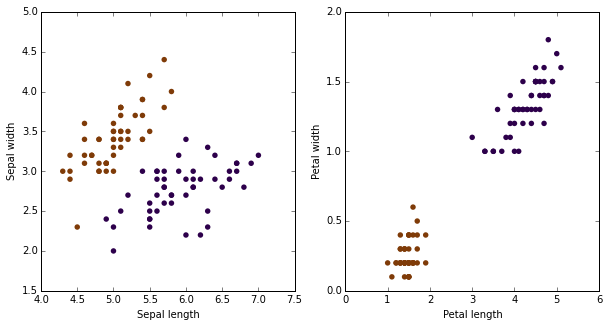

In [173]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

Видно, что классы разделяются, поэтому можно надеяться, что наш алгоритм "найдет" кластеры, соответствующие исходным классам. Результат работы реализованного алгоритма кластеризации предлагается сравнить с эталонной кластеризацией. Для этого предлагается изучить метрику ([adjusted rand score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)). В случае если значение этой метрики отличается от 1, предлагается поработать над улучшением реализации своего алгоритма.

In [174]:
pred_iris = Clustering(K=2, stop=1e-3).fit_predict(x_iris)
print "Adjusted Rand index for iris is: %.2f" % smt.adjusted_rand_score(y_iris, pred_iris)

Adjusted Rand index for iris is: 1.00


Выбрать и реализовать критерий качества, на основании которого будут подбираться параметры модели. Варианты критериев:
- Инерция (сумма квадратов расстояний от каждой из точек до ближайшего к этой точке центроида)
- Средний диаметр (максимальное расстояние между точками в кластере) или радиус (расстояние от центроида до самой дальней от него точки в кластере)
- Sihouette

**Критерий качества необходимо выбрать таким образом, чтобы он подходил для реализованного алгоритма**

In [186]:
#Среднее расстояние внутри кластера
def average_distance_in_C(interval, y, i):
    overlap = y == y[i]
    if not np.any(overlap):
        return 0
    else:
        res = np.mean(interval[overlap])
        return res
    
#Среднее расстояние внe кластера
def average_distance_near_C(interval, y, i):
    label = y[i]
    z = [np.mean(interval[y == cur_label]) for cur_label in set(y) if not cur_label == label]
    if z != []:
        b = np.min(z)
    else:
        b = 0 
    return b

In [176]:
from scipy.spatial import distance

def quality(x, y):
    interval = distance.cdist(x, x)
    A = np.array([average_distance_in_C(interval[i], y, i) for i in range(y.shape[0])])
    B = np.array([average_distance_near_C(interval[i], y, i) for i in range(y.shape[0])])
    silhoette = (B - A) / np.maximum(A, B)
    silhoette = np.mean(silhoette)
    return silhoette

Применим критерий для выбора параметров алгоритма. Предлагается изменить следующий код таким образом, чтобы кластеризация вызывалась с верным набором параметров. На графике можно будет увидеть зависимость критерия от параметров алгоритма. Необходимо выбрать оптимальные значения этих параметров.

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


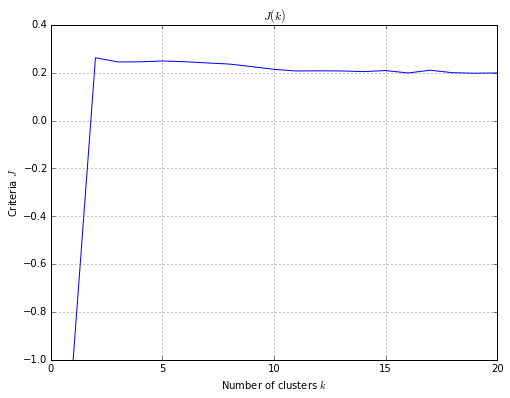

In [187]:
ks = range(1, 21)
criteria = np.zeros(len(ks))

for i, k in enumerate(ks):
    print i
    cls = Clustering(K=k, stop=1e-3)
    y = cls.fit_predict(x)
    criteria[i] = quality(x, y)
    
pl.figure(figsize=(8, 6))
pl.plot(ks, criteria)
pl.title("$J(k)$")
pl.ylabel("Criteria $J$")
pl.xlabel("Number of clusters $k$")
pl.grid()
pl.show()

Далее необходимо кластеризовать данные, используя выбранное количество кластеров, и визуализировать результат с помощью T-SNE. Внимание! На полном объеме данных данный алгоритм может работать существенное время. 

In [189]:
k = 5
cls = Clustering(K=k, stop=1e-3)
y = cls.fit_predict(x)

Визуализируем результаты кластеризации ([подсказка](http://anokhin.github.io/img/hw3_tsne-kmeans.png)). Можно ли сказать, что в двумерном пространстве объекты из одного кластера находятся недалеко? Какой вывод можно сделать о качестве кластеризации?

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 11416
[t-SNE] Computed conditional probabilities for sample 2000 / 11416
[t-SNE] Computed conditional probabilities for sample 3000 / 11416
[t-SNE] Computed conditional probabilities for sample 4000 / 11416
[t-SNE] Computed conditional probabilities for sample 5000 / 11416
[t-SNE] Computed conditional probabilities for sample 6000 / 11416
[t-SNE] Computed conditional probabilities for sample 7000 / 11416
[t-SNE] Computed conditional probabilities for sample 8000 / 11416
[t-SNE] Computed conditional probabilities for sample 9000 / 11416
[t-SNE] Computed conditional probabilities for sample 10000 / 11416
[t-SNE] Computed conditional probabilities for sample 11000 / 11416
[t-SNE] Computed conditional probabilities for sample 11416 / 11416
[t-SNE] Mean sigma: 0.060832
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.420045
[t-SN

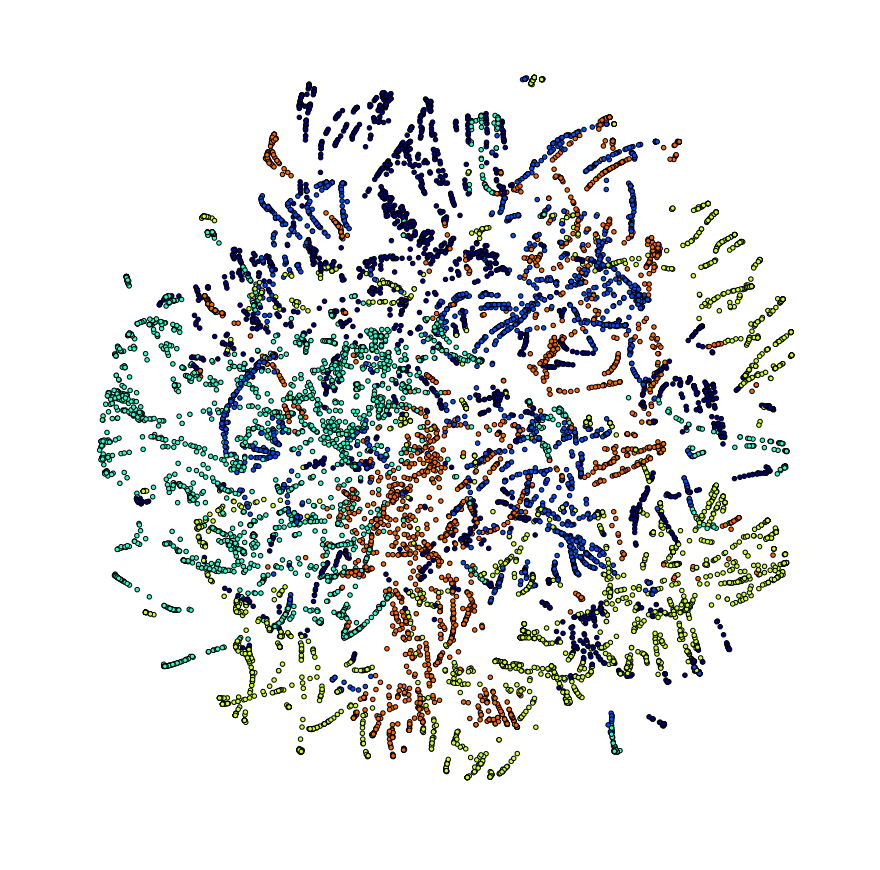

In [190]:
tsne = sm.TSNE(n_components=2, verbose=1, n_iter=1000)
z = tsne.fit_transform(x)

# Color map
cm = pl.get_cmap('jet')
pl.figure(figsize=(15, 15))
pl.scatter(z[:, 0], z[:, 1], c=map(lambda c: cm(1.0 * c / k), y))
pl.axis('off')
pl.show()

Попробуем проанализировать полученные кластеры. Для того, чтобы интерпретировать "суть" каждого из кластеров, построим [radar plot](http://www.wikiwand.com/en/Radar_chart), отображающий их центроиды. Посмотрите на графики и попробуйте объяснить, каким поведением можно охарактеризовать каждый из полученных кластеров? Есть ли среди кластеров похожие?

Реализация радара позаимствована отсюда: 
http://www.science-emergence.com/Matplotlib/MatplotlibGallery/RadarChartMatplotlibRougier/

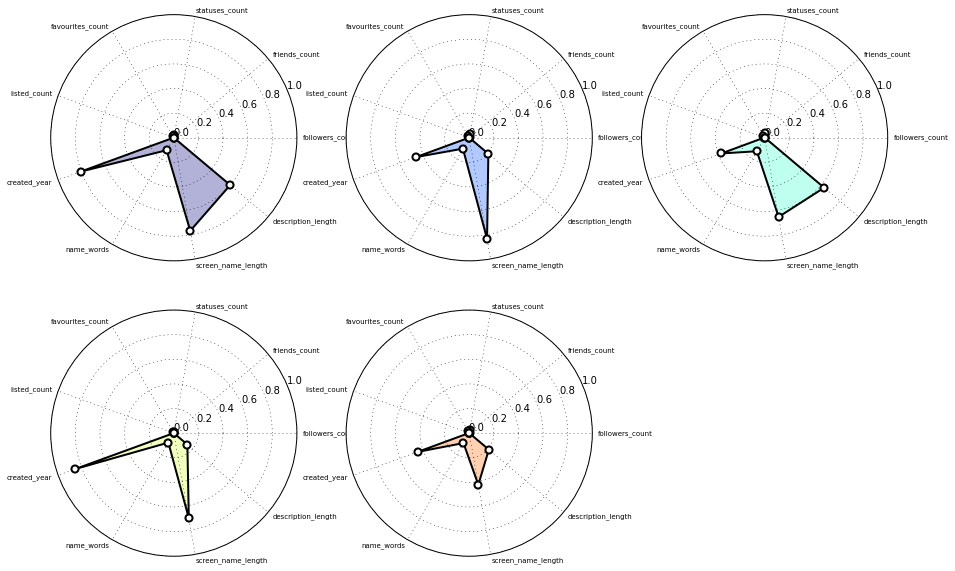

In [191]:
def radar(centroid, features, axes, color):
    # Set ticks to the number of features (in radians)
    t = np.arange(0, 2*np.pi, 2*np.pi/len(features))
    plt.xticks(t, [])

    # Set yticks from 0 to 1
    plt.yticks(np.linspace(0, 1, 6))

    # Draw polygon representing centroid
    points = [(x, y) for x, y in zip(t, centroid)]
    points.append(points[0])
    points = np.array(points)
    codes = [path.Path.MOVETO,] + [path.Path.LINETO,] * (len(centroid) - 1) + [ path.Path.CLOSEPOLY ]
    _path = path.Path(points, codes)
    _patch = patches.PathPatch(_path, fill=True, color=color, linewidth=0, alpha=.3)
    axes.add_patch(_patch)
    _patch = patches.PathPatch(_path, fill=False, linewidth = 2)
    axes.add_patch(_patch)

    # Draw circles at value points
    plt.scatter(points[:,0], points[:,1], linewidth=2, s=50, color='white', edgecolor='black', zorder=10)

    # Set axes limits
    plt.ylim(0, 1)

    # Draw ytick labels to make sure they fit properly
    for i in range(len(features)):
        angle_rad = i/float(len(features))*2*np.pi
        angle_deg = i/float(len(features))*360
        ha = "right"
        if angle_rad < np.pi/2 or angle_rad > 3*np.pi/2: ha = "left"
        plt.text(angle_rad, 1.05, features[i], size=7, horizontalalignment=ha, verticalalignment="center")

# Some additiola imports
import matplotlib
import matplotlib.path as path
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Choose some nice colors
matplotlib.rc('axes', facecolor = 'white')
# Make figure background the same colors as axes 
fig = plt.figure(figsize=(15, 15), facecolor='white')

cm = pl.get_cmap('jet')

clusters = np.unique(y)
for j, cluster in enumerate(clusters):    
    x_c = x[y == cluster]
    centroid = x_c.mean(axis=0)    
    # Use a polar axes
    axes = plt.subplot(3, 3, j + 1, polar=True)
    radar(centroid, data_df.columns.values, axes, cm(1.0 * j / k))

plt.show()

Поздравляем, Вы завершили домашние задания по модулю "Алгоритмы кластеризации". Надеемся, что это было интересно.